## Advanced NLP Challange

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF


/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Challenge: Topic extraction on new data

Take the well-known 20 newsgroups dataset and use each of the methods on it. Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups. Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post. Which works best, and why do you think this is the case?

In [2]:
#read in the dataset from sklearn builtin selecting all categories in the train dataset
twenty_train = fetch_20newsgroups(subset='train',
categories=None, shuffle=True, random_state=42)


In [3]:
dir(twenty_train)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [4]:
len(twenty_train.target_names)

20

In [5]:
labs = twenty_train.target_names

In [6]:
#create a dict mapping the target number to the english label
val_dict = dict([(i,lab) for i,lab in enumerate(labs)])

In [7]:
#create a dataframe to store each news item and its label
news20 = pd.DataFrame()
news20['text'] = twenty_train.data

news20['elabel'] = [val_dict[i] for i in twenty_train.target]

In [8]:
news20.head()

,text,elabel
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space


In [9]:
#clean some of the text and remove email addresses as they distort the word counts
news20['text']= [re.sub("From:\s+\w+@[\w+\.-]*\s\([\w+\s']*\)\nSubject: ",'',i) for i in news20.text]
news20['text']= [re.sub("\S*@\S*\s?",'',i) for i in news20.text]
news20['text']= [re.sub("article",'',i) for i in news20.text]
news20['text']= [re.sub("Nntp-Posting-Host:",'',i) for i in news20.text]
news20['text']= [re.sub("University",'',i) for i in news20.text]
news20['text']= [re.sub("-posting-",'',i) for i in news20.text]

In [10]:
news20.head(2)

,text,elabel
0,WHAT car is this!?\n rac3.wam.umd.edu\nOrganiz...,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final cal...,comp.sys.mac.hardware


The sentences are shuffled in terms of thier categories. We can just use a function to cycle through each category
For each category we need to:
 - Calculate the tfidf matrix
 - Apply different topic extraction methods to extract keyword phrases/topics
 - Assess results

In [11]:
#Set up utility functions and topic extrating methods


#set parameters for results
ntopics = 5
n_top_words = 10

def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

#Instantiate LSA instance
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

#Instatiate LDA instance
#LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )
#NMF
nmf = NMF(alpha=0.0, 
      init='nndsvdar', # how starting value are calculated
      l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
      max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
      n_components=ntopics, 
      random_state=0, 
      solver='cd', # Use Coordinate Descent to solve
      tol=0.0001, # model will stop if tfidf-WH <= tol
      verbose=0 # amount of output to give while iterating
     )


In [12]:
#instantiate vectorizer and extraction parameters
vectorizer = TfidfVectorizer(stop_words='english',max_df=.75,min_df=20)


#create dataframe for all data
topwords_collect = {}

In [13]:
#iterate through each category of news articles and extract topics
for i in news20.elabel.unique():
    print(i)
    category = news20[news20.elabel == i]['text']
    cat_tfidf = vectorizer.fit_transform(category)
    terms = vectorizer.get_feature_names()
    
    # get LSA topics
    cat_lsa = lsa.fit_transform(cat_tfidf)
    comps_lsa = word_topic(cat_tfidf, cat_lsa, terms)
    topwords=pd.DataFrame()
    topwords['LSA']=top_words(comps_lsa, n_top_words)    
    #get LDA topics
    
    cat_lda = lda.fit_transform(cat_tfidf) 
    comps_lda = word_topic(cat_tfidf, cat_lda, terms)
    topwords['LDA']=top_words(comps_lda, n_top_words)
    #get NMF topics
    
    cat_nmf = nmf.fit_transform(cat_tfidf) 
    comps_nmf = word_topic(cat_tfidf, cat_nmf, terms)
    topwords['NNMF']=top_words(comps_nmf, n_top_words)
    topwords_collect[i] = topwords


rec.autos
comp.sys.mac.hardware
comp.graphics
sci.space
talk.politics.guns
sci.med
comp.sys.ibm.pc.hardware
comp.os.ms-windows.misc
rec.motorcycles
talk.religion.misc
misc.forsale
alt.atheism
sci.electronics
comp.windows.x
rec.sport.hockey
rec.sport.baseball
soc.religion.christian
talk.politics.mideast
talk.politics.misc
sci.crypt


In [14]:
for i in labs:
    print('Acutal Category:{}'.format(i))
    tw_df = topwords_collect[i]
    for topic in range(ntopics):
        print('Topic {}:'.format(topic))
        print(tw_df.loc[topic])

Acutal Category:alt.atheism
Topic 0:
              LSA             LDA          NNMF
0       god 22.87     mathew 3.14      god 3.68
0    people 19.45        god 2.17   people 2.23
0        don 16.1    subject 2.08  atheism 1.74
0     think 14.27       news 1.94      don 1.65
0   atheism 12.23        apr 1.87    bible 1.47
0      just 12.03         15 1.83    think 1.43
0  atheists 11.83      bible 1.78  believe 1.43
0      know 11.29    freedom 1.68     just 1.29
0      like 11.16  objective 1.59     does 1.27
0       say 11.02        1993 1.5      say 1.22
Topic 1:
              LSA             LDA            NNMF
1       keith 7.2       god 21.96   morality 3.15
1   morality 6.72    people 17.93  objective 2.59
1  objective 5.43       don 13.83      moral 2.17
1    caltech 4.76     think 12.37        sgi 1.94
1       nntp 4.57   atheism 12.07        jon 1.79
1        sgi 4.51     islam 11.93    natural 1.36
1  political 4.51   islamic 10.86    animals 1.35
1   pasadena 4.46  religio

               LSA                LDA          NNMF
4         read 4.3           car 5.52     read 1.94
4     warning 4.06          just 5.51     kids 1.94
4        kids 3.71          fast 5.23       don 1.9
4   insurance 3.22        writes 4.81  warning 1.77
4  automotive 2.48           130 4.32   writes 1.55
4      people 2.44         speed 4.16   people 1.51
4         ago 2.36          good 3.91      car 1.44
4     dumbest 1.92  distribution 3.65     cars 1.36
4          hit 1.9          cars 3.63    think 1.25
4          20 1.89          road 3.51     just 1.16
Acutal Category:rec.motorcycles
Topic 0:
            LSA           LDA         NNMF
0    bike 31.64  behanna 2.37    bike 3.73
0  writes 27.11     bike 2.35  writes 2.56
0      dod 21.6    chris 2.31     dod 2.07
0    like 20.13   writes 2.05    just 2.01
0    just 18.58      dod 1.88    like 1.99
0     don 17.76     wild 1.81     bmw 1.88
0     new 15.12    glide 1.75     don 1.87
0    know 14.88     pack 1.73      new 1.7


              LSA              LDA             NNMF
1        fbi 9.95         000 1.56         fbi 3.54
1       batf 6.98         gun 1.32        batf 2.86
1        atf 6.16      people 1.14    compound 1.77
1        waco 4.8        batf 1.11        waco 1.64
1   compound 4.65        rate 1.08      koresh 1.58
1   children 4.53         usa 0.98      people 1.54
1     koresh 4.16     handgun 0.96    children 1.52
1  survivors 4.04  population 0.87      writes 1.31
1        gas 3.96      writes 0.84  government 1.21
1      ranch 3.44         waco 0.8         gas 1.18
Topic 2:
              LSA              LDA           NNMF
2         atf 4.0         gun 0.88       atf 2.17
2      ranch 3.64      writes 0.67  survivors 1.6
2      stove 3.58      people 0.65     ranch 1.57
2   dividian 3.52        guns 0.58   stratus 1.56
2      texas 3.45         don 0.53  dividian 1.54
2      burns 3.35         like 0.5    writes 1.54
2  survivors 3.28         fbi 0.49     stove 1.51
2    posting 2.97  

In [15]:
#Examining Sparsity of a subject
auto = news20[news20.elabel == 'rec.autos']['text']
auto_tfidf = vectorizer.fit_transform(auto)
aterms = vectorizer.get_feature_names()

# get LSA topics
auto_lsa = lsa.fit_transform(auto_tfidf)
auto_comps_lsa = word_topic(auto_tfidf, auto_lsa, aterms)
t_words=pd.DataFrame()
t_words['LSA']=top_words(auto_comps_lsa, n_top_words)    
#get LDA topics

auto_lda = lda.fit_transform(auto_tfidf) 
auto_comps_lda = word_topic(auto_tfidf, auto_lda, aterms)
t_words['LDA']=top_words(auto_comps_lda, n_top_words)
#get NMF topics

auto_nmf = nmf.fit_transform(auto_tfidf) 
auto_comps_nmf = word_topic(auto_tfidf, auto_nmf, aterms)
t_words['NNMF']=top_words(auto_comps_nmf, n_top_words)


In [16]:
t_words.head()

,LSA,LDA,NNMF
0,car 35.58,kids 2.89,car 4.5
0,writes 22.05,cars 2.04,cars 1.61
0,just 19.73,hp 1.84,new 1.6
0,cars 19.49,don 1.81,dealer 1.6
0,like 17.8,car 1.79,price 1.49


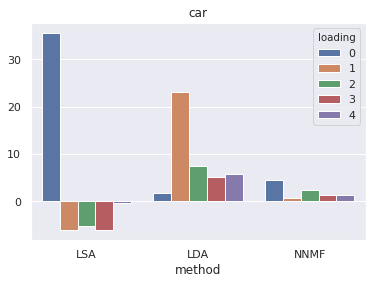

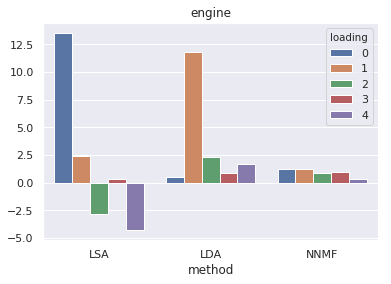

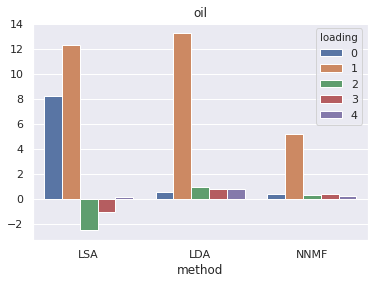

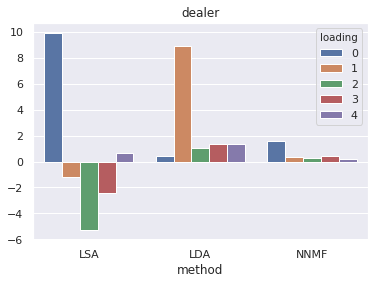

In [17]:
#chose some topwords
# The words to look at.
targetwords=['car','engine','oil','dealer']

wordloadings=pd.DataFrame(columns=targetwords)

for word in targetwords:
    loadings=auto_comps_lsa.loc[word].append(
        auto_comps_lda.loc[word]).append(
            auto_comps_nmf.loc[word])
    wordloadings[word]=loadings
    
# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

## Examining loadings for the same words in opposite categories
Atheism vs Christian

In [18]:
ath = news20[news20.elabel == 'alt.atheism']['text']
christ = news20[news20.elabel == 'soc.religion.christian']['text']

ath_tfidf = vectorizer.fit_transform(ath)
athterms = vectorizer.get_feature_names()
christ_tfidf = vectorizer.fit_transform(christ)
cterms = vectorizer.get_feature_names()

ath_words = pd.DataFrame()
christ_words = pd.DataFrame()

# get LSA topics
ath_lsa = lsa.fit_transform(ath_tfidf)
ath_comps_lsa = word_topic(ath_tfidf, ath_lsa, athterms)
ath_words['LSA']=top_words(ath_comps_lsa, n_top_words)    

christ_lsa = lsa.fit_transform(christ_tfidf)
christ_comps_lsa = word_topic(christ_tfidf, christ_lsa, cterms)
ath_words['LSA']=top_words(christ_comps_lsa, n_top_words)    


#get LDA topics

ath_lda = lda.fit_transform(ath_tfidf) 
ath_comps_lda = word_topic(ath_tfidf, ath_lda, athterms)
ath_words['LDA']=top_words(ath_comps_lda, n_top_words)

christ_lda = lda.fit_transform(christ_tfidf) 
christ_comps_lda = word_topic(christ_tfidf, christ_lda, cterms)
christ_words['LDA']=top_words(christ_comps_lda, n_top_words)

#get NMF topics

ath_nmf = nmf.fit_transform(ath_tfidf) 
ath_comps_nmf = word_topic(ath_tfidf, ath_nmf, athterms)
ath_words['NNMF']=top_words(ath_comps_nmf, n_top_words)

christ_nmf = nmf.fit_transform(christ_tfidf) 
christ_comps_nmf = word_topic(christ_tfidf, christ_nmf, cterms)
christ_words['NNMF']=top_words(christ_comps_nmf, n_top_words)

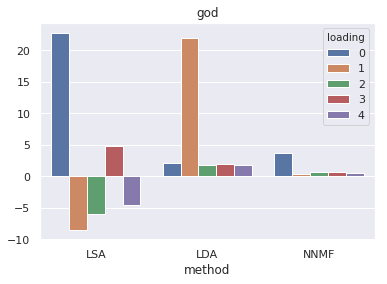

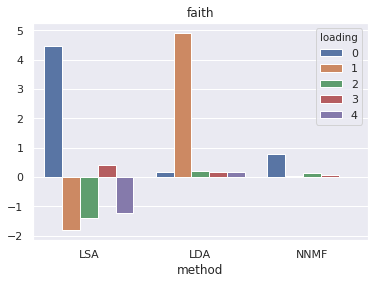

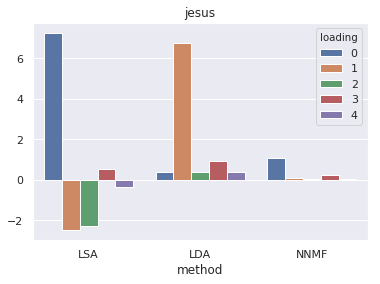

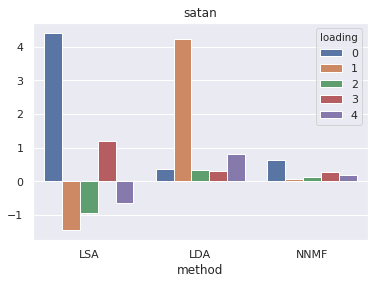

In [19]:
targetwords=['god','faith','jesus','satan']

wordloadings=pd.DataFrame(columns=targetwords)

for word in targetwords:
    loadings=ath_comps_lsa.loc[word].append(
        ath_comps_lda.loc[word]).append(
            ath_comps_nmf.loc[word])
    wordloadings[word]=loadings
    
# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

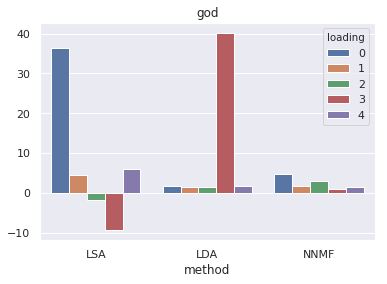

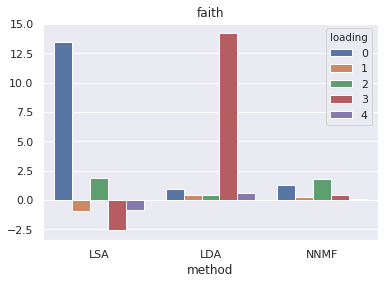

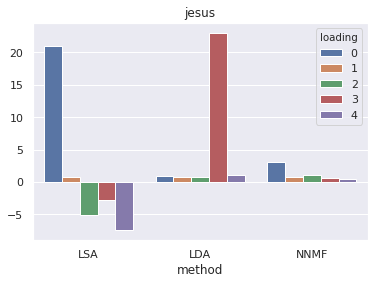

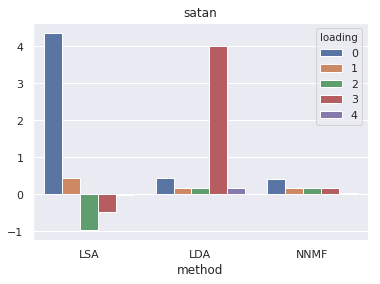

In [20]:
wordloadings=pd.DataFrame(columns=targetwords)

for word in targetwords:
    loadings=christ_comps_lsa.loc[word].append(
        christ_comps_lda.loc[word]).append(
            christ_comps_nmf.loc[word])
    wordloadings[word]=loadings
    
# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

Looking at loadings for Atheism and Religion.christain